<a href="https://colab.research.google.com/github/edmenciab733/hackaton2023/blob/main/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías 

Se instalan las librerías necesarias
- datasets
- ntlk 
- transformers
- peft


In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q nltk
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install -q evaluate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Se cargan las librerías necesariás

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn import metrics
import matplotlib.pyplot as plt

# Dataset
- Se carga stopwords
- Se carga el dataset Sintomas.xlsx
- Se convierte el los padecimientos en una variable númerica llamada Padecimiento_Cat
- Se crean los diccionarios  id2label - label2id para que el pipeline dé los resultados
- Se define el numero de posibles resultados

In [3]:
%%capture
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1EOAx7_OmuKArEo-vM9NaMOXDPVtk3hjOwpcLX4rYnUI/edit#gid=0').sheet1

data = pd.DataFrame.from_records(worksheet.get_all_values())
data.columns = data.iloc[0]
data = data.drop(data.index[0])

In [5]:
data.head()

,Sintoma,Padecimiento
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica


In [6]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_cat'] = labelencoder.transform(data['Padecimiento'])

In [7]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id_aux = str(id)
   id2label[id_aux] = i
   label2id[i] = id_aux

In [8]:
id2label, label2id

({'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'},
 {'Trastornos de la personalidad antisocial': '0',
  'Trastornos de la personalidad borderline': '1',
  'Trastornos de la personalidad esquizotípica': '2',
  'Trastornos de la personalidad histriónica': '3',
  'Trastornos de la personalidad narcisista': '4'})

In [9]:
target_nro = len(labelencoder.classes_)
target_nro

5

In [10]:
data.head()

,Sintoma,Padecimiento,Padecimiento_cat
1,"Desde que era joven, ha tenido la creencia de ...",Trastornos de la personalidad esquizotípica,2
2,Tiene la superstición de que si no sigue ciert...,Trastornos de la personalidad esquizotípica,2
3,"A menudo experimenta ilusiones corporales, com...",Trastornos de la personalidad esquizotípica,2
4,"Su discurso a menudo es vago y metafórico, lo ...",Trastornos de la personalidad esquizotípica,2
5,Tiene la tendencia a pensar que las personas a...,Trastornos de la personalidad esquizotípica,2


Resumen del balance de los datos

In [11]:
data.Padecimiento.value_counts()

Trastornos de la personalidad borderline       358
Trastornos de la personalidad antisocial       250
Trastornos de la personalidad histriónica      250
Trastornos de la personalidad narcisista       250
Trastornos de la personalidad esquizotípica    225
Name: Padecimiento, dtype: int64

In [12]:
stopwords = set(stopwords.words('spanish'))

In [13]:
import re
def eliminar_acento(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def eliminar_patrones_stopwords(text):
  text = [word for word in text.strip().split() if not word in stopwords]
  text = ' '.join(text)
  return text

def eliminar_espacios_blancos(texto):
    text = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"\:|\_", '', texto)
    texto = re.sub(r"o\/a", 'o', texto)
    
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto
    
def clean_text(original):
    original = re.sub(r'\w+(?:\.+\w+)*', lambda x: x.group(0).replace('.', ' '), original)
    original = re.sub(r'\.','' , original)

    texto = eliminar_acento(original)
    texto = eliminar_espacios_blancos(texto)
    texto = re.sub(r" +", ' ', texto)
   
    texto = texto.lower()
    texto = eliminar_patrones_stopwords(texto)
    original =  re.sub(r" +", ' ', texto)
    return texto

In [14]:
data = data.sample(frac=1).reset_index(drop=True)

In [15]:
data["Sintoma_limpia"] = [clean_text(x) for x in data["Sintoma"]]
data.head()

,Sintoma,Padecimiento,Padecimiento_cat,Sintoma_limpia
0,La falta de empatía y la ausencia de remordimi...,Trastornos de la personalidad antisocial,0,falta empatia ausencia remordimiento patrones ...
1,Este individuo siempre busca ser el centro de ...,Trastornos de la personalidad histriónica,3,individuo siempre busca ser centro atencion cu...
2,Dificultad para controlar los estallidos de ir...,Trastornos de la personalidad borderline,1,dificultad controlar estallidos ira colera ina...
3,Él se siente más cómodo hablando solo o en com...,Trastornos de la personalidad esquizotípica,2,mas comodo hablando solo compañia familiares c...
4,"Su estilo de comunicación es superficial, basa...",Trastornos de la personalidad histriónica,3,estilo comunicacion superficial basado impresi...


Nube de palabras para establecer los usos entender un poco el dataset

In [16]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                 
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

En caso de querer filtrar la nube de palabras reemplazar stopwords_by_cat por el valor deseado. 0, 1, 2,3, 4

{'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'},

In [17]:
def stopwords_by_cat(df, cat):
  df_cat = df.loc[df['Padecimiento_cat'] == cat]
  all_text = ' '.join(list(df_cat["Sintoma_limpia"].values))
  return all_text

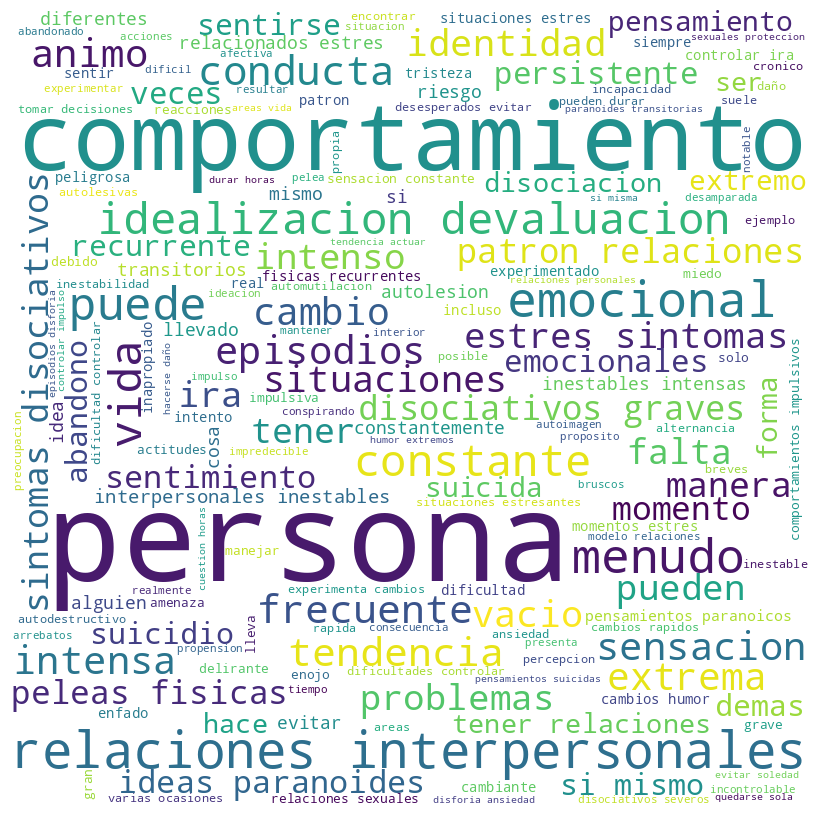

In [18]:
nube_palabras(stopwords_by_cat(data, 1))

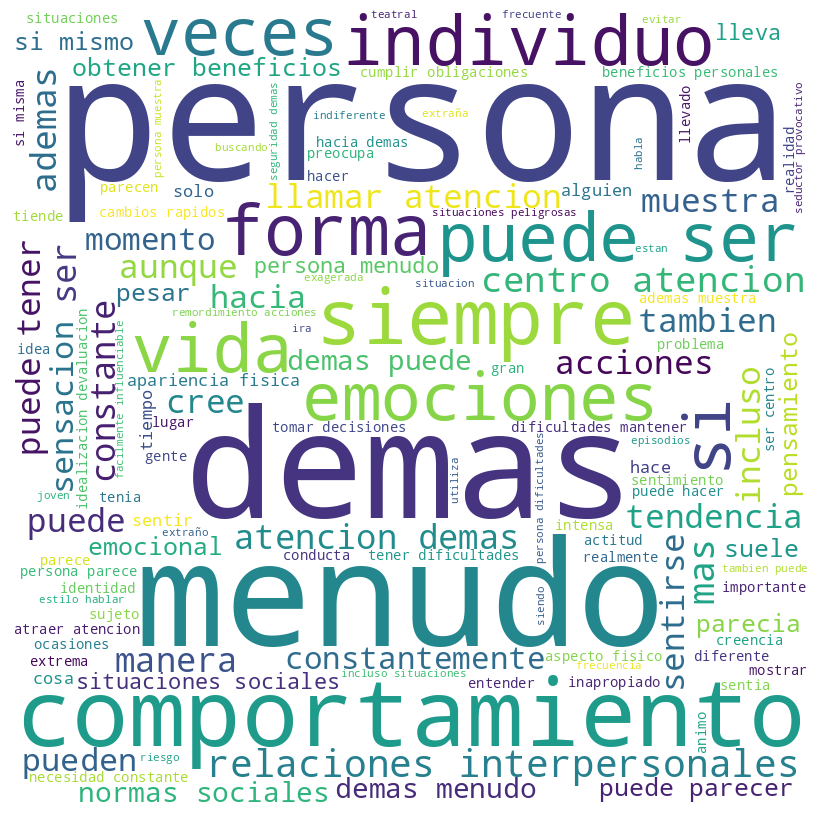

In [19]:
all_text = ' '.join(list(data["Sintoma_limpia"].values))
nube_palabras(all_text)
del all_text

# FineTuning
- Conversión de pandas a dataset(hugginface)
- Renombre de las columnas adecuedas
- Split train-test de los datos


In [20]:
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_column("Sintoma_limpia", "text")
dataset = dataset.rename_column("Padecimiento_cat", "label")

In [21]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['Sintoma', 'Padecimiento', 'label', 'text'],
        num_rows: 1199
    })
    test: Dataset({
        features: ['Sintoma', 'Padecimiento', 'label', 'text'],
        num_rows: 134
    })
})

## Carga de los modelos
-  Carga dccuchile/bert-base-spanish-wwm-cased
-  Preparación de los paramestros de entrenamiento
-  Entrenamiento
-  Guarda de los modelos de entrenamientos


Carga del modelo ber en español

In [22]:
model_id="dccuchile/bert-base-spanish-wwm-cased"
#model_id = "xlm-roberta-base"

nameFT = "default"
if model_id == "xlm-roberta-base":
  nameFT = "DiagTrast-xlm-roberta-base"
elif model_id == "dccuchile/bert-base-spanish-wwm-cased":
  nameFT = "DiagTrast-Berto"

In [23]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [24]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [25]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1199 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [27]:
metric = evaluate.load("accuracy")

In [28]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [29]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [31]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198555,0.962687
2,No log,0.204609,0.962687
3,No log,0.213919,0.962687


TrainOutput(global_step=450, training_loss=0.3056524658203125, metrics={'train_runtime': 354.3043, 'train_samples_per_second': 10.152, 'train_steps_per_second': 1.27, 'total_flos': 946435958443008.0, 'train_loss': 0.3056524658203125, 'epoch': 3.0})

In [32]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.2139185220003128,
 'eval_accuracy': 0.9626865671641791,
 'eval_runtime': 4.7308,
 'eval_samples_per_second': 28.325,
 'eval_steps_per_second': 3.593,
 'epoch': 3.0}

In [33]:
index = 1
tokenized_datasets["test"][index]["Sintoma"], tokenized_datasets["test"][index]["label"]

('Tiene una personalidad impulsiva y a menudo actúa sin pensar en las consecuencias de sus acciones. Esto le ha llevado a meterse en problemas y a tomar decisiones arriesgadas que han tenido consecuencias graves.',
 0)

In [34]:
predict= trainer.predict(tokenized_datasets["test"])

In [35]:
preds = np.argmax(predict.predictions, axis=-1)

In [36]:
df_evaluate = pd.DataFrame(tokenized_datasets["test"] ) 
df_evaluate['prediction'] = preds

{'0': 'Trastornos de la personalidad antisocial',
  '1': 'Trastornos de la personalidad borderline',
  '2': 'Trastornos de la personalidad esquizotípica',
  '3': 'Trastornos de la personalidad histriónica',
  '4': 'Trastornos de la personalidad narcisista'}


In [37]:
labels = data.Padecimiento_cat.unique()

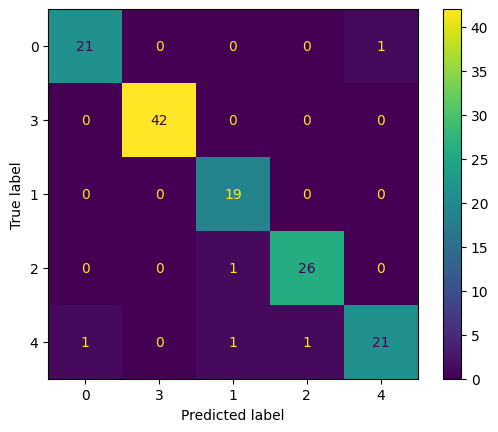

In [38]:
confusion_matrix = metrics.confusion_matrix(df_evaluate['label'], df_evaluate['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()

In [39]:
model_folder = "./" + nameFT
# Save tokenizer
tokenizer.save_pretrained(model_folder)
# Save model
trainer.save_model(model_folder)

# Testing Model

In [40]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_folder)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_folder)

In [41]:
from transformers import pipeline

In [42]:
classifier = pipeline("text-classification", model=model_folder)

In [43]:
text = ["Gasta más dinero de lo que tiene, a menudo, su falta de control hace que esté en deudas", 
        "Le gusta estar solo y le molesta la gente a su alrededor, solo piensa en él",
        "Tiene pocas habilidades sociales, ignora normas de convivencia", 
        "Siempre que está en falta, culpa a los demás de sus problemas" ]

# XAI Model

In [45]:
%%capture
!pip install captum

In [46]:
import torch
import pandas as pd

from torch import tensor 

from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase

import matplotlib.pyplot as plt

class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list, prediction: dict):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], 
                         index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        
        predicted_label = prediction[0]["label"]

        plt.title(predicted_label)
        
        plt.show(a.plot.barh(figsize=(10,5)))
                      
    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline.predict(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, self.__pipeline.model.roberta.embeddings)

        label2id = self.__pipeline.model.config.label2id[prediction[0]['label']] 
        label2id = int(label2id)
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = label2id, 
                                  return_convergence_delta = True)
        
        
        
        self.visualize(inputs, attributes, prediction)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)
    

In [47]:
device = "cpu"
exp_model = ExplainableTransformerPipeline(model_folder, classifier, device)

# Upload model

In [52]:
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q
from huggingface_hub import notebook_login

def push_model_to_hub(dir, name):
  model = AutoModelForSequenceClassification.from_pretrained(dir, 
                                                             num_labels=target_nro, 
                                                             id2label=id2label, 
                                                             label2id=label2id, 
                                                             return_dict=True)
  tokenizer = AutoTokenizer.from_pretrained(dir)

  model.push_to_hub(name, use_temp_dir=True)
  tokenizer.push_to_hub(name, use_temp_dir=True)

#!huggingface-cli login
#notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [53]:
#push_model_to_hub(model_folder, 'hackathon-somos-nlp-2023/'+nameFT)

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
#Dataset.from_pandas(data).push_to_hub('hackathon-somos-nlp-2023/DiagTrast')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

# Tests

In [55]:
texto2 = 'Propensión a hacer elecciones riesgosas y precipitadas.'
exp_model.explain(clean_text(texto2))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in explain:54                                                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1614 in __getattr__            │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'BertForSequenceClassification' object has no attribute 'roberta'

In [ ]:
texto3 = 'Inclinación hacia la adopción de opciones imprudentes y rápidas.'
exp_model.explain(clean_text(texto3))

In [ ]:
texto4 = 'Esta persona se siente superior a los demás y espera ser tratado como tal, incluso en situaciones donde no es justificado.'
exp_model.explain(clean_text(texto4))

In [ ]:
texto5 = 'Soy superior al resto de las personas y me gusta que me tratén como ser superior.'
exp_model.explain(clean_text(texto5))

In [ ]:
texto7 = 'Soy mejor persona que el resto del mundo'
exp_model.explain(clean_text(texto7))

In [ ]:
texto8 = 'Creo que no hay nadie más guapo que yo'
exp_model.explain(clean_text(texto8))

In [ ]:
texto9 = 'La gente debería estar agradecida de estar cerca de mí'
exp_model.explain(clean_text(texto9))

In [ ]:
texto10 = 'Tiene una necesidad profunda de admiracion y atención por los demas'
exp_model.explain(clean_text(texto10))

In [ ]:
texto11 = 'Tiene un interes desmesurado de su propia importancia'
exp_model.explain(clean_text(texto11))